# Computational Finance
## Lab Assignment 1
### Adrian + Daan + Menno 

In [66]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Option Valuation using Binomial Trees

We are trying to provide the risk-free fair price for an Option Call, a financial derivative that gives the option holder the right to buy an underlying security at one or many future events.

We assume:

- A two state economy, the price of the underlying can go up or down
- Money can be invested risk free for a constant interest rate
- There is no arbitrage or transaction costs

In [192]:
def binomialTree(S, sigma, T, N, r, K, option_type='Call', origin = 'European'):
    # Time step
    dt = T / N

    # Possible price movements
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Matrix that will hold the values
    matrix = tree = np.zeros((N + 1, N + 1))

    matrix[0, 0] = S

    # Populate the matrix with the stock price progression
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            if j == 0:
                matrix[i, j] = matrix[i-1, j] * d
            else:
                matrix[i, j] = matrix[i-1, j-1] * u

    # Price at each step
    p = (np.exp(r*dt) - d) / (u - d)

    # Hedge amount at each step
    # delta = (up - down) / (s * u - s * d)
    tree = matrix
    columns = tree.shape[1] 
    rows = tree.shape[0]

    # Calculate the price for the expiration day nodes
    for c in np.arange(columns):
        S = tree[rows - 1, c] # Value in the matrix
        if option_type == 'Call':
            tree[rows - 1, c] =  max(0, S - K) 
        else: 
            tree[rows - 1, c] =  max(0, K - S) # Put option

    # Backwards Induction through the nodes
    for i in np.arange(rows - 1)[:: -1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if origin == "European":

                tree[i, j] = np.exp(-r*dt) * (p * up + (1-p) * down)

            elif origin == 'American':
                tree[i, j] = max(tree[i, j] - K, np.exp(-r*dt) * (p * up + (1-p) * down))

    fu = tree[1][1]
    fd = tree[1][0]

    delta = (fu - fd) / (100 * u - 100 * d)
    
    return tree[0][0], delta

In [102]:
def blackSholes(S, K, t, r, sigma, option_type='Call'):
    # Time to maturity
    tau = T - t

    # Parameters
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    # Hedge amount at t
    delta = norm.cdf(d1)

    if option_type == 'Call':
        call_price = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
        return call_price, delta
    else:
        put_price = (np.exp(-r*tau) * K * norm.cdf(-d2)) - (S * norm.cdf(-d1))
        return put_price, delta

In [103]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 # Volatility of the stock

In [98]:
test_bt = binomialTree(S, sigma, T, N, r, K)
print(test_bt[0])

test_bs = blackSholes(S, K, t, r, sigma)
print(test_bs[0])

11.546434850755034
11.544280227051097


In [99]:
def plot_errors(max_steps=500):
    bs_price = blackSholes(S, K, t, r, sigma)[0]
    errors = []
    steps = []

    for N in range(30, max_steps, 5):
        errors.append(abs(bs_price-binomialTree(S, sigma, T, N, r, K)))
        steps.append(N)
    plt.plot(steps,errors)
    plt.xlabel('Step')
    plt.ylabel('Error')

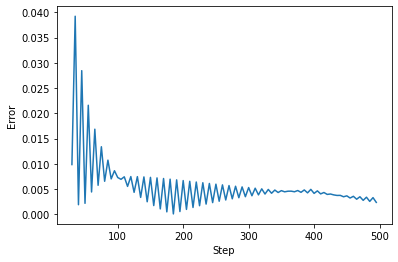

In [72]:
plot_errors()

In [297]:
# 1.2 approximation with different volatilities
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 

def plot_volatilities():
    sigmas = []
    tree_price = []
    bs_price = []
    difference=[]
    for sigma in np.linspace(0, 1, 44):
        bs_price.append(blackSholes(S, K, t, r, sigma)[0])
        tree_price.append(binomialTree(S, sigma, T, N, r, K)[0])
        difference.append(abs(bs_price[-1] - tree_price[-1]))
        sigmas.append(sigma)

    # plt.plot(sigmas,tree_price,label='Binomial Tree')
    # plt.plot(sigmas,tree_price,label='Black-Scholes')
    plt.plot(sigmas, difference)
    plt.xlabel('Volatility', fontsize=12)
    plt.ylabel('Absolute difference in option price', fontsize=12)
    plt.savefig("1b")

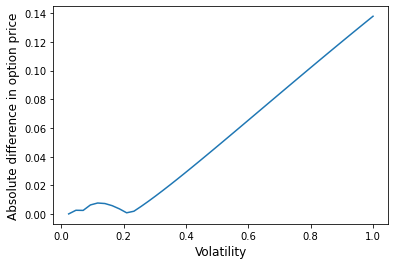

In [299]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 
plot_volatilities()

In [300]:
# 1.3
def plot_difference(max_steps=1001):
    bs_price = bs_price = blackSholes(S, K, t, r, sigma)[0]
    tree_price = []
    steps = []
    for N in range(50, max_steps, 5):
        tree_price.append(binomialTree(S, sigma, T, N, r, K)[0])
        steps.append(N)
    plt.plot(steps,tree_price,label='Binomial Tree')
    print(steps)
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    plt.plot([steps[0],steps[-1]],[bs_price,bs_price],color='Black',label='Black Sholes')
    plt.legend()
    plt.tight_layout()
    plt.savefig("1c")

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000]


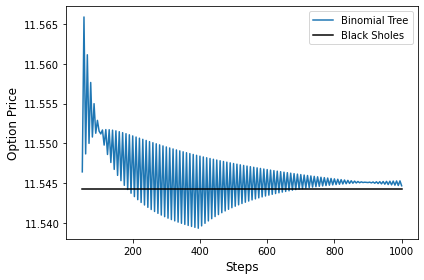

In [301]:
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 
plot_difference()

In [302]:
# 1.5
def plot_volatility():
    sigmas = []
    hedges_bs = []
    hedges_bt = []
    difference = []
    for sigma in np.linspace(0,1,44):
        hedges_bs.append(blackSholes(S, K, t, r, sigma)[1])
        hedges_bt.append(binomialTree(S, sigma, T, N, r, K)[1])
        difference.append(abs(hedges_bs[-1] - hedges_bt[-1]))
        sigmas.append(sigma)

    print(sigmas)
    # plt.plot(sigmas, hedges_bs, label="Black-Scholes")
    # plt.plot(sigmas, hedges_bt, label="Binomial Tree")
    plt.plot(sigmas, difference)
    plt.xlabel('Volatility', fontsize=12)
    plt.ylabel("Difference in $\Delta_0$", fontsize=12)
    plt.tight_layout()
    plt.savefig("1e")

[0.0, 0.023255813953488372, 0.046511627906976744, 0.06976744186046512, 0.09302325581395349, 0.11627906976744186, 0.13953488372093023, 0.16279069767441862, 0.18604651162790697, 0.20930232558139533, 0.23255813953488372, 0.2558139534883721, 0.27906976744186046, 0.3023255813953488, 0.32558139534883723, 0.3488372093023256, 0.37209302325581395, 0.3953488372093023, 0.41860465116279066, 0.4418604651162791, 0.46511627906976744, 0.4883720930232558, 0.5116279069767442, 0.5348837209302325, 0.5581395348837209, 0.5813953488372093, 0.6046511627906976, 0.627906976744186, 0.6511627906976745, 0.6744186046511628, 0.6976744186046512, 0.7209302325581395, 0.7441860465116279, 0.7674418604651163, 0.7906976744186046, 0.813953488372093, 0.8372093023255813, 0.8604651162790697, 0.8837209302325582, 0.9069767441860465, 0.9302325581395349, 0.9534883720930233, 0.9767441860465116, 1.0]


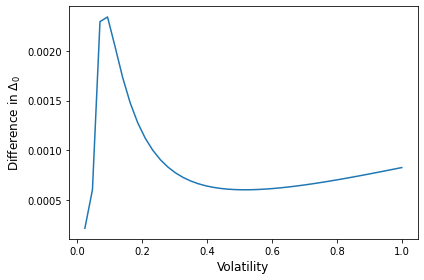

In [303]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 
plot_volatility()

In [295]:
def plot_variety():
    a_put = []
    a_call = []
    e_put = []
    e_call = []
    sigmas = []

    for sigma in np.linspace(0,1,44):
        a_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'American')[0])
        a_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'American')[0])
        e_put.append(binomialTree(S, sigma, T, N, r, K,option_type='Put', origin = 'European')[0])
        e_call.append(binomialTree(S, sigma, T, N, r, K,option_type='Call', origin = 'European')[0])
        sigmas.append(sigma)
    plt.plot(sigmas,a_put, label='American Put')
    plt.plot(sigmas,a_call, label='American Call')
    plt.plot(sigmas,e_put, label='European Put')
    plt.plot(sigmas,e_call, label='European Call')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.legend()
    plt.savefig("1f")

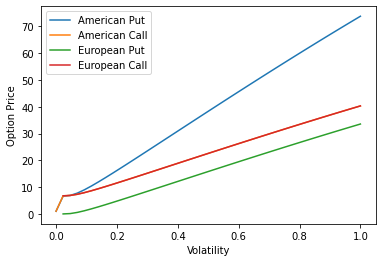

In [296]:
plot_variety()

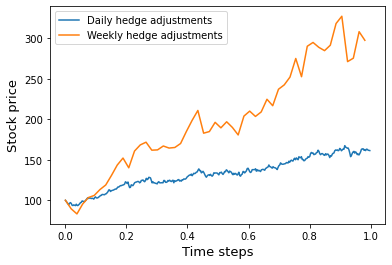

In [289]:
# 2.2
sigma = 0.2
r = 0.06
S0 = 100
K = 99
T = 1

# daily hedging adjustments
day_S = [S0]
M = 365
tau = 1
dt = T/M
day_z = [np.random.normal(0,1) for _ in range(M)]
day_d1s = []

for m in range(M):
    z = day_z[m]
    current_S = day_S[-1]
    S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

    d1 = np.log(S/K) + (r + 0.5 * sigma**2) * tau
    d1 = d1 / (sigma * np.sqrt(tau))

    day_d1s.append(d1)
    day_S.append(S)
    tau -= dt

# weekly hedging adjustments
week_S = [S0]
M = 52
tau = 1
dt = T/M
week_z = [np.sum(day_z[x:x+7]) for x in range(0, len(day_z), 7)]
week_d1s = []

for m in range(M):
    z = week_z[m]
    current_S = week_S[-1]
    S = current_S + r*current_S*dt + sigma * current_S * np.sqrt(dt) * z

    d1 = np.log(S/K) + (r + 0.5 * sigma**2) * tau
    d1 = d1 / (sigma * np.sqrt(tau))

    week_d1s.append(d1)
    week_S.append(S)
    tau -= dt

plt.plot(np.arange(0, 1, 1/366), day_S, label="Daily hedge adjustments")
plt.plot(np.arange(0, 1, 1/53), week_S, label="Weekly hedge adjustments")
plt.xlabel("Time steps", fontsize=13)
plt.ylabel("Stock price", fontsize=13)
plt.legend()
# plt.savefig("2b")